In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

In [2]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

<h1>Data Loading</h1>

In [3]:
try:
    customers_df = pd.read_csv("../data/processed/customers_processed.csv")
    orders_df = pd.read_csv("../data/processed/orders_processed.csv")
    
    print(f"Customers dataset loaded: {customers_df.shape}")
    print(f"Orders dataset loaded: {orders_df.shape}")
    
except FileNotFoundError:
    print("Files not found. Please ensure the CSV files are in the correct path.")
    print("Expected files: 'customers_df.csv', 'orders_df.csv'")

Customers dataset loaded: (99092, 5)
Orders dataset loaded: (99092, 8)


<h1>Data Preparation</h1>

In [4]:
date_columns = [
    'order_purchase_dt', 'order_approved_dt', 
    'order_delivered_carrier_dt', 'order_delivered_customer_dt', 
    'order_estimated_delivery_dt'
]

for col in date_columns:
    if col in orders_df.columns:
        orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
        print(f"Converted {col} to datetime")

Converted order_purchase_dt to datetime
Converted order_approved_dt to datetime
Converted order_delivered_carrier_dt to datetime
Converted order_delivered_customer_dt to datetime
Converted order_estimated_delivery_dt to datetime


In [5]:
merged_df = orders_df.merge(customers_df, on='customer_id', how='left')
print(f"Data merged successfully: {merged_df.shape[0]} records")

Data merged successfully: 99092 records


In [6]:
delivered_orders = merged_df[(merged_df['order_status'] == 'delivered') & 
    (merged_df['order_delivered_customer_dt'].notna())].copy()
print(f"Focusing on delivered orders: {delivered_orders.shape[0]} records")

Focusing on delivered orders: 96203 records


<H1>1. Average Time Between Order Stages</H1>

In [7]:
def calculate_stage_times(df):
    """Calculate time differences between order stages"""
    
    df['purchase_to_approval_hours'] = (
        df['order_approved_dt'] - df['order_purchase_dt']
    ).dt.total_seconds() / 3600
    
    df['approval_to_carrier_hours'] = (
        df['order_delivered_carrier_dt'] - df['order_approved_dt']
    ).dt.total_seconds() / 3600
    
    df['carrier_to_customer_hours'] = (
        df['order_delivered_customer_dt'] - df['order_delivered_carrier_dt']
    ).dt.total_seconds() / 3600
    
    df['total_delivery_hours'] = (
        df['order_delivered_customer_dt'] - df['order_purchase_dt']
    ).dt.total_seconds() / 3600
    
    df['delivery_vs_estimate_hours'] = (
        df['order_delivered_customer_dt'] - df['order_estimated_delivery_dt']
    ).dt.total_seconds() / 3600
    
    return df

delivered_orders = calculate_stage_times(delivered_orders)

stage_times = {
    'Purchase to Approval': delivered_orders['purchase_to_approval_hours'].mean(),
    'Approval to Carrier': delivered_orders['approval_to_carrier_hours'].mean(),
    'Carrier to Customer': delivered_orders['carrier_to_customer_hours'].mean(),
    'Total Delivery Time': delivered_orders['total_delivery_hours'].mean()
}

for stage, avg_time in stage_times.items():
    if not np.isnan(avg_time):
        days = avg_time / 24
        print(f"{stage:20}: {avg_time:.1f} hours ({days:.1f} days)")
    else:
        print(f"{stage:20}: Data not available")

time_columns = ['purchase_to_approval_hours', 'approval_to_carrier_hours', 'carrier_to_customer_hours']
for col in time_columns:
    if col in delivered_orders.columns:
        positive_values = delivered_orders[col][delivered_orders[col] >= 0]
        if len(positive_values) > 0:
            median_val = positive_values.median()
            delivered_orders[col] = delivered_orders[col].where(delivered_orders[col] >= 0, median_val)

Purchase to Approval: 10.2 hours (0.4 days)
Approval to Carrier : 66.5 hours (2.8 days)
Carrier to Customer : 224.2 hours (9.3 days)
Total Delivery Time : 300.9 hours (12.5 days)


<h3>Creating visualization for times it would take for each stage</h3>

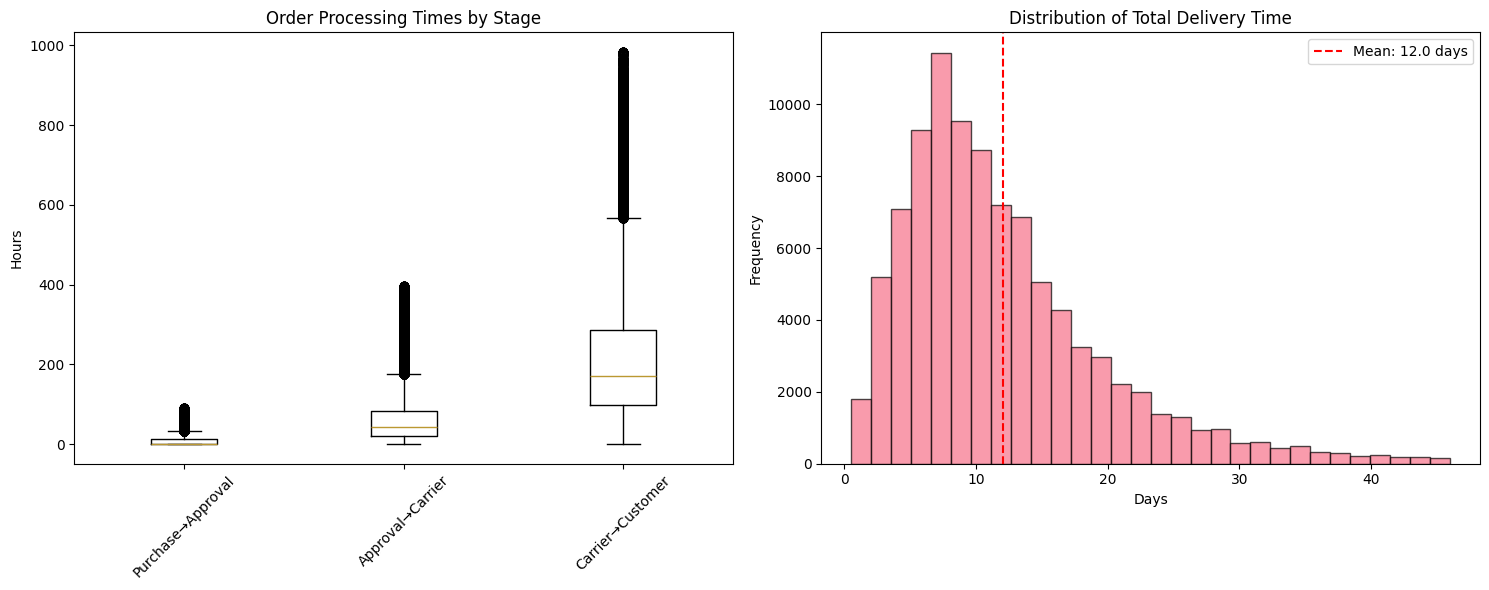

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

stage_data = []
stage_labels = []
for key, col in [('Purchase→Approval', 'purchase_to_approval_hours'),
                 ('Approval→Carrier', 'approval_to_carrier_hours'),
                 ('Carrier→Customer', 'carrier_to_customer_hours')]:
    if col in delivered_orders.columns:
        valid_data = delivered_orders[col].dropna()
        valid_data = valid_data[valid_data <= valid_data.quantile(0.99)]
        if len(valid_data) > 0:
            stage_data.append(valid_data)
            stage_labels.append(key)

if stage_data:
    ax1.boxplot(stage_data, labels=stage_labels)
    ax1.set_title('Order Processing Times by Stage')
    ax1.set_ylabel('Hours')
    ax1.tick_params(axis='x', rotation=45)

total_delivery = delivered_orders['total_delivery_hours'].dropna()
total_delivery = total_delivery[total_delivery <= total_delivery.quantile(0.99)]  # Remove outliers

ax2.hist(total_delivery/24, bins=30, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Total Delivery Time')
ax2.set_xlabel('Days')
ax2.set_ylabel('Frequency')
ax2.axvline(x=(total_delivery/24).mean(), color='red', linestyle='--', 
           label=f'Mean: {(total_delivery/24).mean():.1f} days')
ax2.legend()

plt.tight_layout()
plt.show()

<h5>Analysis shows that the average delivery time to customers is approximately 12 days. To improve this performance, the business should consider expanding warehouse coverage in strategic regions and implementing more efficient routing to carriers. These measures directly address the stages of the process within operational control, whereas the carrier-to-customer segment remains largely external. By optimizing warehouse locations and logistics routing, the company can significantly reduce overall delivery times and enhance service reliability.</h5>

<h1>2. Regional Delivery Performance</h1>

In [9]:
regional_performance = delivered_orders.groupby('customer_state').agg({
    'total_delivery_hours': ['mean', 'median', 'count'],
    'delivery_vs_estimate_hours': 'mean'
}).round(2)

regional_performance.columns = ['avg_delivery_hours', 'median_delivery_hours', 'order_count', 'avg_vs_estimate_hours']
regional_performance = regional_performance.reset_index()

#convert to days for readability
regional_performance['avg_delivery_days'] = regional_performance['avg_delivery_hours'] / 24
regional_performance['median_delivery_days'] = regional_performance['median_delivery_hours'] / 24
regional_performance['avg_vs_estimate_days'] = regional_performance['avg_vs_estimate_hours'] / 24

# Filter states with reasonable order volume (at least 100 orders)
regional_performance = regional_performance[regional_performance['order_count'] >= 100]

regional_performance = regional_performance.sort_values('avg_delivery_days')

<h3>Regional Performance Analysis</h3>

In [10]:
best_regions = regional_performance.head(5)
worst_regions = regional_performance.tail(5)

<h5>Best Performing Regions</h5>

In [11]:
print(f"{'State':<8} {'Avg Days':<10} {'Median Days':<12} {'Orders':<8} {'vs Estimate':<12}")
for _, row in best_regions.iterrows():
    print(f"{row['customer_state']:<8} {row['avg_delivery_days']:<10.1f} {row['median_delivery_days']:<12.1f} "
          f"{row['order_count']:<8.0f} {row['avg_vs_estimate_days']:<12.1f}")

State    Avg Days   Median Days  Orders   vs Estimate 
SP       8.7        7.2          40399    -10.3       
PR       12.0       10.4         4903     -12.5       
MG       12.0       10.3         11319    -12.5       
DF       12.9       11.4         2074     -11.3       
SC       14.9       13.0         3537     -10.7       



<h5>Worst Performing Regions</h5>

In [12]:
print(f"{'State':<8} {'Avg Days':<10} {'Median Days':<12} {'Orders':<8} {'vs Estimate':<12}")
for _, row in worst_regions.iterrows():
    print(f"{row['customer_state']:<8} {row['avg_delivery_days']:<10.1f} {row['median_delivery_days']:<12.1f} "
          f"{row['order_count']:<8.0f} {row['avg_vs_estimate_days']:<12.1f}")

State    Avg Days   Median Days  Orders   vs Estimate 
SE       21.4       17.9         332      -9.2        
MA       21.5       19.2         713      -8.7        
PA       23.8       21.1         942      -13.3       
AL       24.5       22.3         396      -8.0        
AM       26.4       25.9         145      -18.9       




<h3>Creating visualization of regional performance</h3>

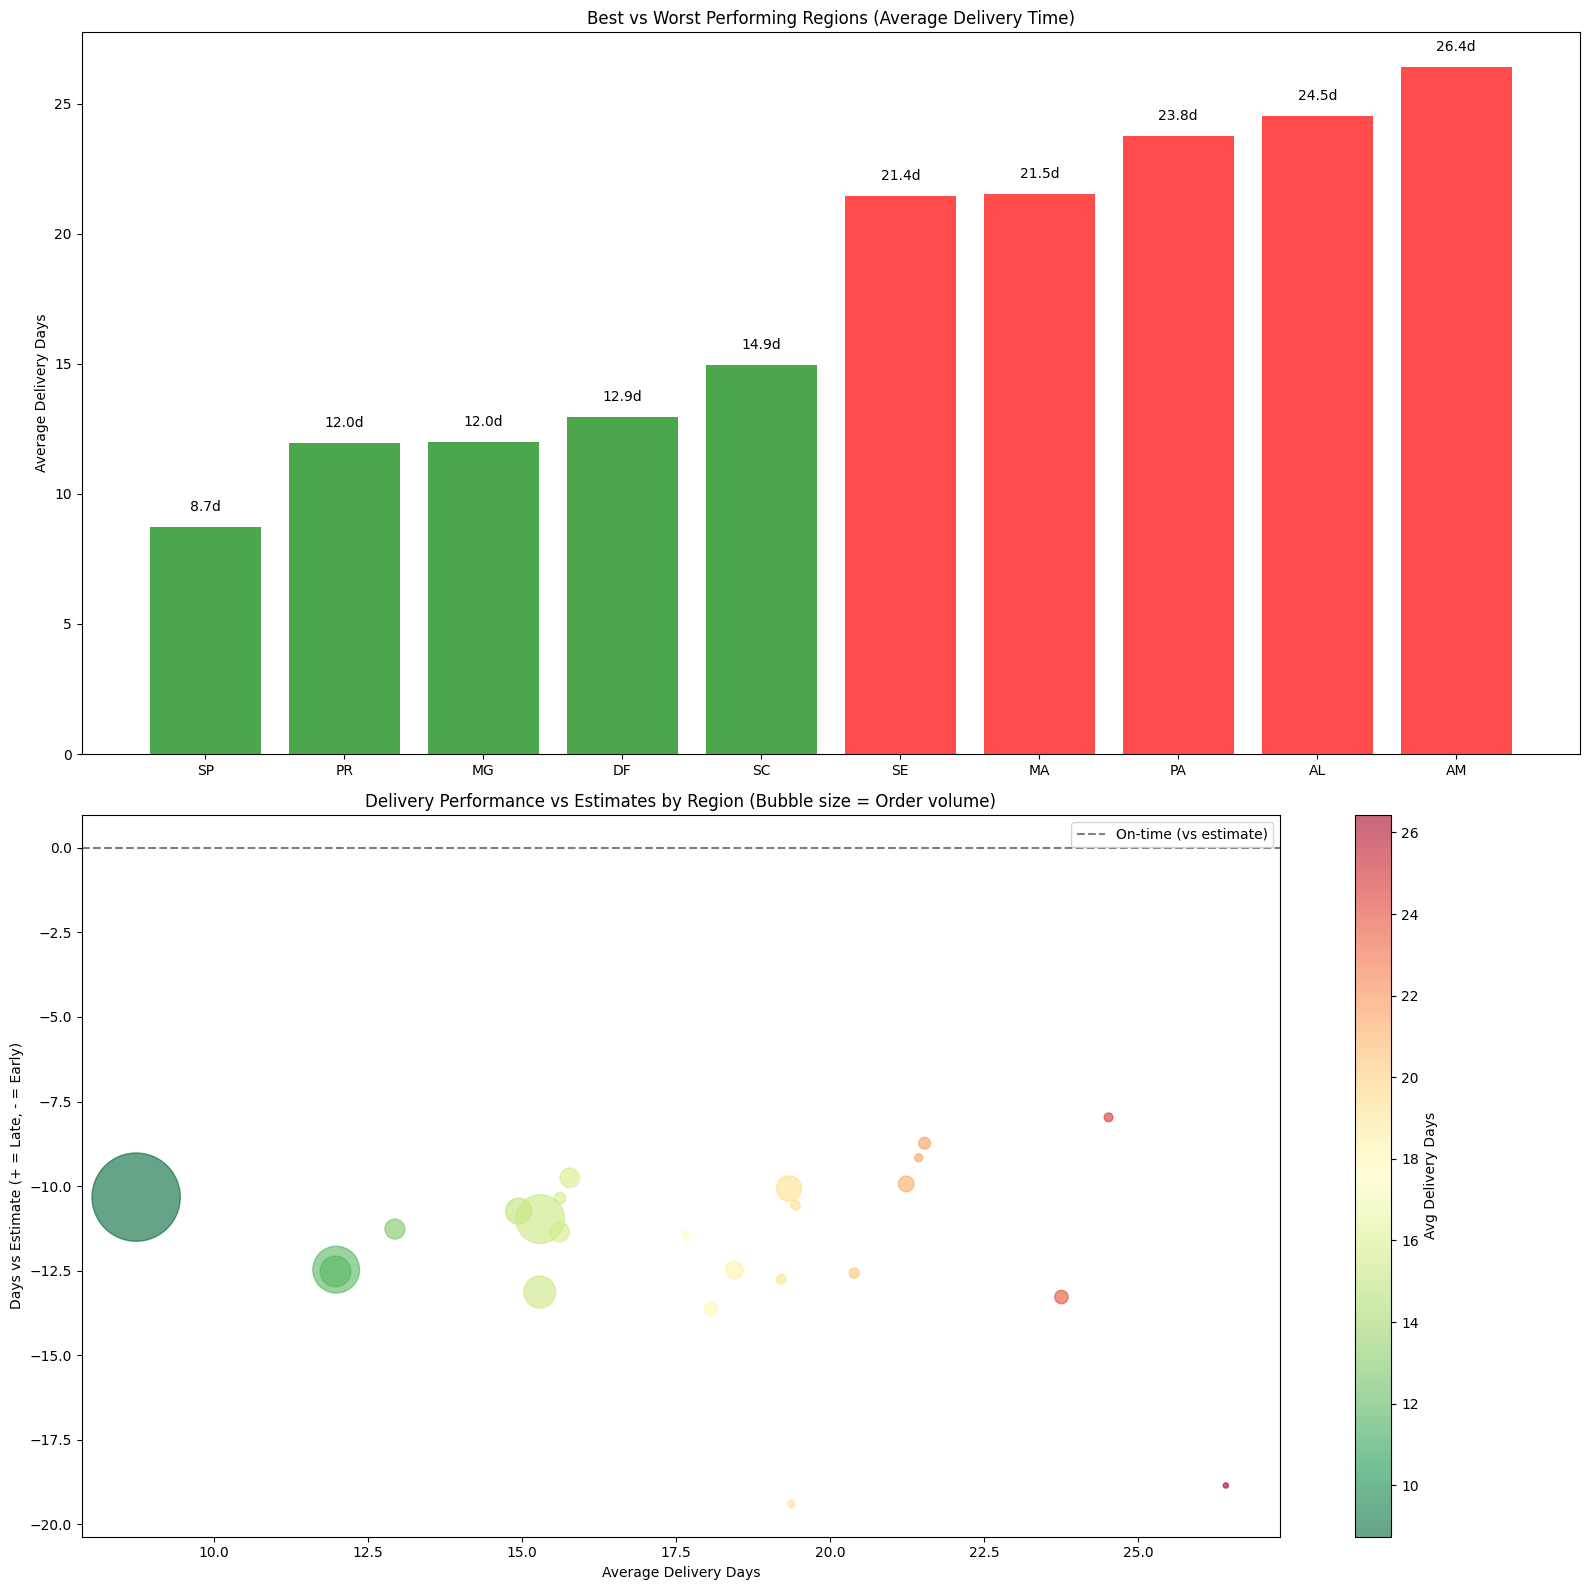

In [13]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

top_bottom = pd.concat([best_regions, worst_regions])
colors = ['green'] * 5 + ['red'] * 5

bars = ax1.bar(range(len(top_bottom)), top_bottom['avg_delivery_days'], color=colors, alpha=0.7)
ax1.set_title('Best vs Worst Performing Regions (Average Delivery Time)')
ax1.set_ylabel('Average Delivery Days')
ax1.set_xticks(range(len(top_bottom)))
ax1.set_xticklabels(top_bottom['customer_state'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}d', ha='center', va='bottom')

ax2.scatter(regional_performance['avg_delivery_days'], 
           regional_performance['avg_vs_estimate_days'],
           s=regional_performance['order_count']/10, 
           alpha=0.6, c=regional_performance['avg_delivery_days'], 
           cmap='RdYlGn_r')

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='On-time (vs estimate)')
ax2.set_xlabel('Average Delivery Days')
ax2.set_ylabel('Days vs Estimate (+ = Late, - = Early)')
ax2.set_title('Delivery Performance vs Estimates by Region (Bubble size = Order volume)')
ax2.legend()

plt.colorbar(ax2.collections[0], ax=ax2, label='Avg Delivery Days')

plt.tight_layout()
plt.show()

<h5>This show that there are certain regions have double the average delivery time. These might affect our chance of retaining customers from those region and should be addressed accordingly. Adding more warehouse location and updating routes should help minimize the required days. Properly adjusting the estimated delivery especially for the poor performing regions would also help as this would not break the expectations of the customer</h5>

<h1>3. Order Approval Time Impact</h1>

In [14]:
delivered_orders['approval_time_hours'] = (
    (delivered_orders['order_approved_dt'] - delivered_orders['order_purchase_dt']).dt.total_seconds() / 3600
)
delivered_orders['delivery_time_hours'] = (
    (delivered_orders['order_delivered_customer_dt'] - delivered_orders['order_purchase_dt']).dt.total_seconds() / 3600 
)

<h5>Replace negative or impossible values with the median value of the same column</h5>

In [15]:
for col in ['approval_time_hours', 'delivery_time_hours']:
    median_val = delivered_orders.loc[delivered_orders[col] >= 0, col].median()
    delivered_orders[col] = delivered_orders[col].apply(lambda x: median_val if x < 0 else x)

In [16]:


median_approval = delivered_orders['approval_time_hours'].median()
delivered_orders['approval_speed'] = delivered_orders['approval_time_hours'].apply(
    lambda x: 'Fast' if x <= median_approval else 'Slow'
)

median_approval = delivered_orders['approval_time_hours'].median()
delivered_orders['approval_speed'] = delivered_orders['approval_time_hours'].apply(
    lambda x: 'Fast' if x <= median_approval else 'Slow'
)

<h3>Visualization of the Approval Time Impact</h3>

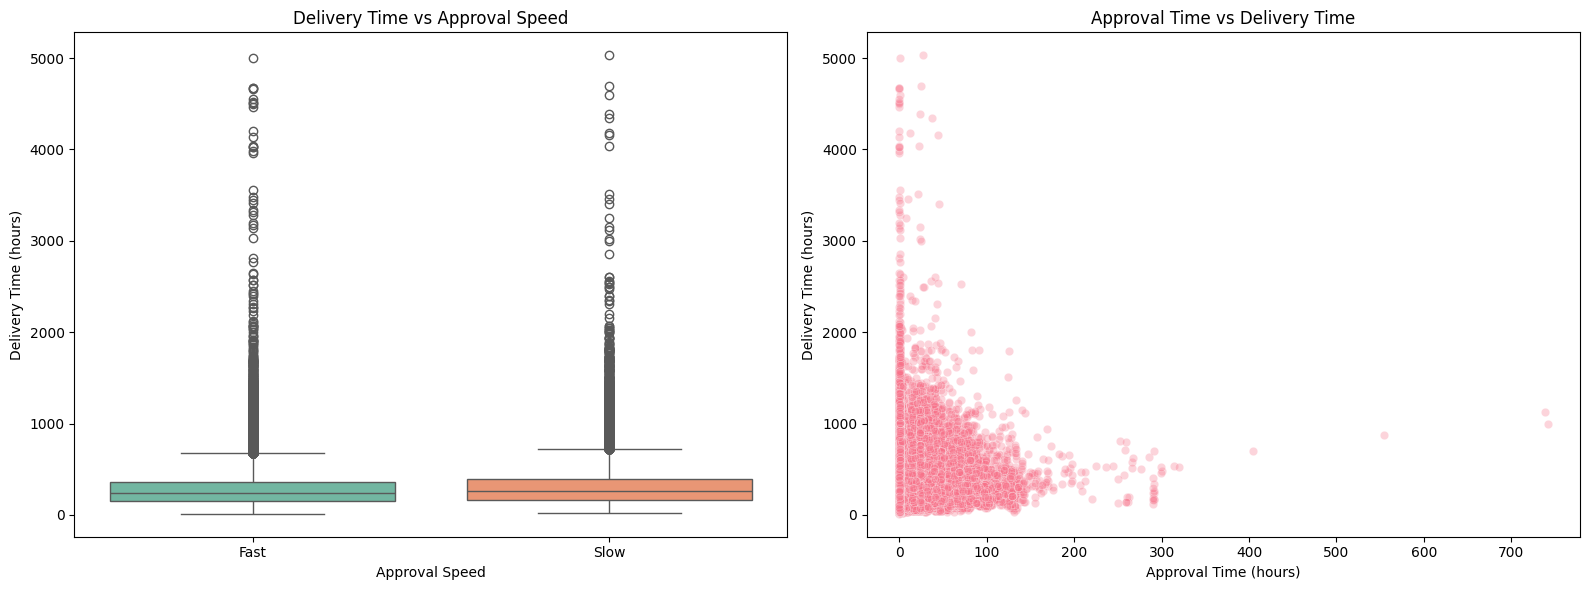

Pearson correlation between approval time and delivery time: 0.08


In [17]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot: Delivery time grouped by approval speed
sns.boxplot(x='approval_speed', y='delivery_time_hours', data=delivered_orders, ax=ax1, palette="Set2")
ax1.set_title("Delivery Time vs Approval Speed")
ax1.set_ylabel("Delivery Time (hours)")
ax1.set_xlabel("Approval Speed")

# Scatterplot: Approval time vs Delivery time
sns.scatterplot(
    x='approval_time_hours',
    y='delivery_time_hours',
    data=delivered_orders,
    alpha=0.3,
    ax=ax2
)
ax2.set_title("Approval Time vs Delivery Time")
ax2.set_xlabel("Approval Time (hours)")
ax2.set_ylabel("Delivery Time (hours)")

plt.tight_layout()
plt.show()

# --- Correlation ---
pearson_corr = delivered_orders[['approval_time_hours', 'delivery_time_hours']].corr(method='pearson').iloc[0,1]
print(f"Pearson correlation between approval time and delivery time: {pearson_corr:.2f}")

<h5>The correlation indicates that the relationship between approval speed and delivery time is very weak. While faster approval remains operationally important, it is not a key driver of overall delivery speed. This suggests that the primary bottlenecks likely occur after the approval stage, within later parts of the fulfillment process.</h5>

<h1>4. Bottleneck Identification Across Stages</h1>

In [18]:
stage_columns = ['purchase_to_approval_hours', 'approval_to_carrier_hours', 'carrier_to_customer_hours']
analysis_df = delivered_orders.copy()


In [19]:



analysis_df['order_month'] = analysis_df['order_purchase_dt'].dt.to_period('M')
analysis_df['order_year_month'] = analysis_df['order_purchase_dt'].dt.strftime('%Y-%m')

print(f"Analyzing {len(analysis_df)} delivered orders for bottlenecks...")


Analyzing 96203 delivered orders for bottlenecks...


<h3>Time-based Bottleneck Analysis</h3>

In [20]:
stage_stats = {}
stage_names = {
    'purchase_to_approval_hours': 'Purchase → Approval',
    'approval_to_carrier_hours': 'Approval → Carrier', 
    'carrier_to_customer_hours': 'Carrier → Customer'
}

for col, name in stage_names.items():
    if col in analysis_df.columns:
        valid_data = analysis_df[col].dropna()
        valid_data = valid_data[valid_data >= 0]  # Remove any remaining negative values
        
        if len(valid_data) > 0:
            stage_stats[name] = {
                'mean_hours': valid_data.mean(),
                'median_hours': valid_data.median(),
                'std_hours': valid_data.std(),
                'cv': valid_data.std() / valid_data.mean() if valid_data.mean() > 0 else 0,
                'p75_hours': valid_data.quantile(0.75),
                'p95_hours': valid_data.quantile(0.95),
                'count': len(valid_data)
            }

total_process_time = sum([stats['mean_hours'] for stats in stage_stats.values()])

In [21]:
print(f"{'STAGE':<20} {'AVG TIME':<12} {'% OF TOTAL':<12} {'VARIABILITY':<15} {'P95 TIME':<12}")
for stage, stats in sorted(stage_stats.items(), key=lambda x: x[1]['mean_hours'], reverse=True):
    pct_contribution = (stats['mean_hours'] / total_process_time) * 100
    avg_days = stats['mean_hours'] / 24
    p95_days = stats['p95_hours'] / 24
    variability = "High" if stats['cv'] > 1.0 else "Medium" if stats['cv'] > 0.5 else "Low"
    
    print(f"{stage:<20} {avg_days:<12.1f} {pct_contribution:<12.1f}% {variability:<15} {p95_days:<12.1f}")

STAGE                AVG TIME     % OF TOTAL   VARIABILITY     P95 TIME    
Carrier → Customer   9.3          74.3        % Medium          24.2        
Approval → Carrier   2.8          22.3        % High            8.0         
Purchase → Approval  0.4          3.4         % High            2.0         


<h3>Variability Bottleneck Analysis</h3>

In [22]:
variability_analysis = []
for stage, stats in stage_stats.items():
    variability_analysis.append({
        'stage': stage,
        'coefficient_of_variation': stats['cv'],
        'consistency_score': 1 / (1 + stats['cv']),  # Higher score = more consistent
        'avg_hours': stats['mean_hours']
    })

variability_df = pd.DataFrame(variability_analysis)
variability_df = variability_df.sort_values('coefficient_of_variation', ascending=False)

In [23]:
print(f"{'STAGE':<20} {'CV SCORE':<12} {'CONSITENCY':<15} {'PREDICTABILY':<15}")
for _, row in variability_df.iterrows():
    cv_score = row['coefficient_of_variation']
    consistency = "Poor" if cv_score > 1.0 else "Fair" if cv_score > 0.5 else "Good"
    predictability = "Low" if cv_score > 1.0 else "Medium" if cv_score > 0.5 else "High"
    
    print(f"{row['stage']:<20} {cv_score:<12.2f} {consistency:<15} {predictability:<15}")


STAGE                CV SCORE     CONSITENCY      PREDICTABILY   
Purchase → Approval  2.00         Poor            Low            
Approval → Carrier   1.20         Poor            Low            
Carrier → Customer   0.94         Fair            Medium         


<h3>Regional Bottleneck Analysis</h3>

In [24]:
regional_bottlenecks = []

for state in analysis_df['customer_state'].value_counts().head(10).index: 
    state_data = analysis_df[analysis_df['customer_state'] == state]
    
    if len(state_data) >= 50:  
        state_bottlenecks = {'state': state, 'order_count': len(state_data)}
        
        stage_times = {}
        for col, name in stage_names.items():
            if col in state_data.columns:
                valid_data = state_data[col].dropna()
                valid_data = valid_data[valid_data >= 0]
                if len(valid_data) > 0:
                    stage_times[name] = valid_data.mean()
        if stage_times:
            slowest_stage = max(stage_times, key=stage_times.get)
            state_bottlenecks['primary_bottleneck'] = slowest_stage
            state_bottlenecks['bottleneck_time_days'] = stage_times[slowest_stage] / 24
            state_bottlenecks['total_delivery_days'] = state_data['total_delivery_hours'].mean() / 24
            
            regional_bottlenecks.append(state_bottlenecks)

In [25]:
regional_bottlenecks_df = pd.DataFrame(regional_bottlenecks)
regional_bottlenecks_df = regional_bottlenecks_df.sort_values('bottleneck_time_days', ascending=False)

In [26]:
print(f"{'STATE':<8} {'PRIMARY BOTTLENECK':<20} {'BOTTLENECK':<12} {'TOTAL DELIVERY':<15}")
for _, row in regional_bottlenecks_df.head(8).iterrows():
    print(f"{row['state']:<8} {row['primary_bottleneck']:<20} {row['bottleneck_time_days']:<12.1f} {row['total_delivery_days']:<15.1f}")

STATE    PRIMARY BOTTLENECK   BOTTLENECK   TOTAL DELIVERY 
BA       Carrier → Customer   16.0         19.3           
GO       Carrier → Customer   12.5         15.6           
ES       Carrier → Customer   12.4         15.8           
RS       Carrier → Customer   12.1         15.3           
RJ       Carrier → Customer   12.0         15.3           
SC       Carrier → Customer   11.7         14.9           
DF       Carrier → Customer   9.8          12.9           
PR       Carrier → Customer   8.8          12.0           


<H3>Temporal Bottleneck Analysis</H3>

In [27]:
monthly_bottlenecks = []
for month in sorted(analysis_df['order_year_month'].unique()):
    month_data = analysis_df[analysis_df['order_year_month'] == month]
    
    if len(month_data) >= 100:  # Minimum sample size
        month_analysis = {'month': month, 'order_count': len(month_data)}
        
        # Find dominant bottleneck for this month
        stage_times = {}
        for col, name in stage_names.items():
            if col in month_data.columns:
                valid_data = month_data[col].dropna()
                valid_data = valid_data[valid_data >= 0]
                if len(valid_data) > 0:
                    stage_times[name] = valid_data.mean()
        
        if stage_times:
            dominant_stage = max(stage_times, key=stage_times.get)
            month_analysis['dominant_bottleneck'] = dominant_stage
            month_analysis['bottleneck_time_days'] = stage_times[dominant_stage] / 24
            month_analysis['total_delivery_days'] = month_data['total_delivery_hours'].mean() / 24
            
            monthly_bottlenecks.append(month_analysis)

monthly_df = pd.DataFrame(monthly_bottlenecks)

In [28]:
if len(monthly_df) > 0:
    print(f"{'MONTH':<10} {'BOTTLENECK DOMINANSCE':<20} {'Bottleneck Days':<15}")
    
    for _, row in monthly_df.iterrows():
        print(f"{row['month']:<10} {row['dominant_bottleneck']:<20} {row['bottleneck_time_days']:<15.1f}")

MONTH      BOTTLENECK DOMINANSCE Bottleneck Days
2017-01    Carrier → Customer   9.2            
2017-02    Carrier → Customer   9.6            
2017-03    Carrier → Customer   9.8            
2017-04    Carrier → Customer   11.2           
2017-05    Carrier → Customer   8.3            
2017-06    Carrier → Customer   8.9            
2017-07    Carrier → Customer   8.5            
2017-08    Carrier → Customer   8.1            
2017-09    Carrier → Customer   8.6            
2017-10    Carrier → Customer   8.4            
2017-11    Carrier → Customer   11.1           
2017-12    Carrier → Customer   11.7           
2018-01    Carrier → Customer   10.5           
2018-02    Carrier → Customer   13.4           
2018-03    Carrier → Customer   13.0           
2018-04    Carrier → Customer   8.7            
2018-05    Carrier → Customer   8.7            
2018-06    Carrier → Customer   6.7            
2018-07    Carrier → Customer   6.1            
2018-08    Carrier → Customer   5.2    

<H3>Comprehensive Bottleneck Visualization</H3>

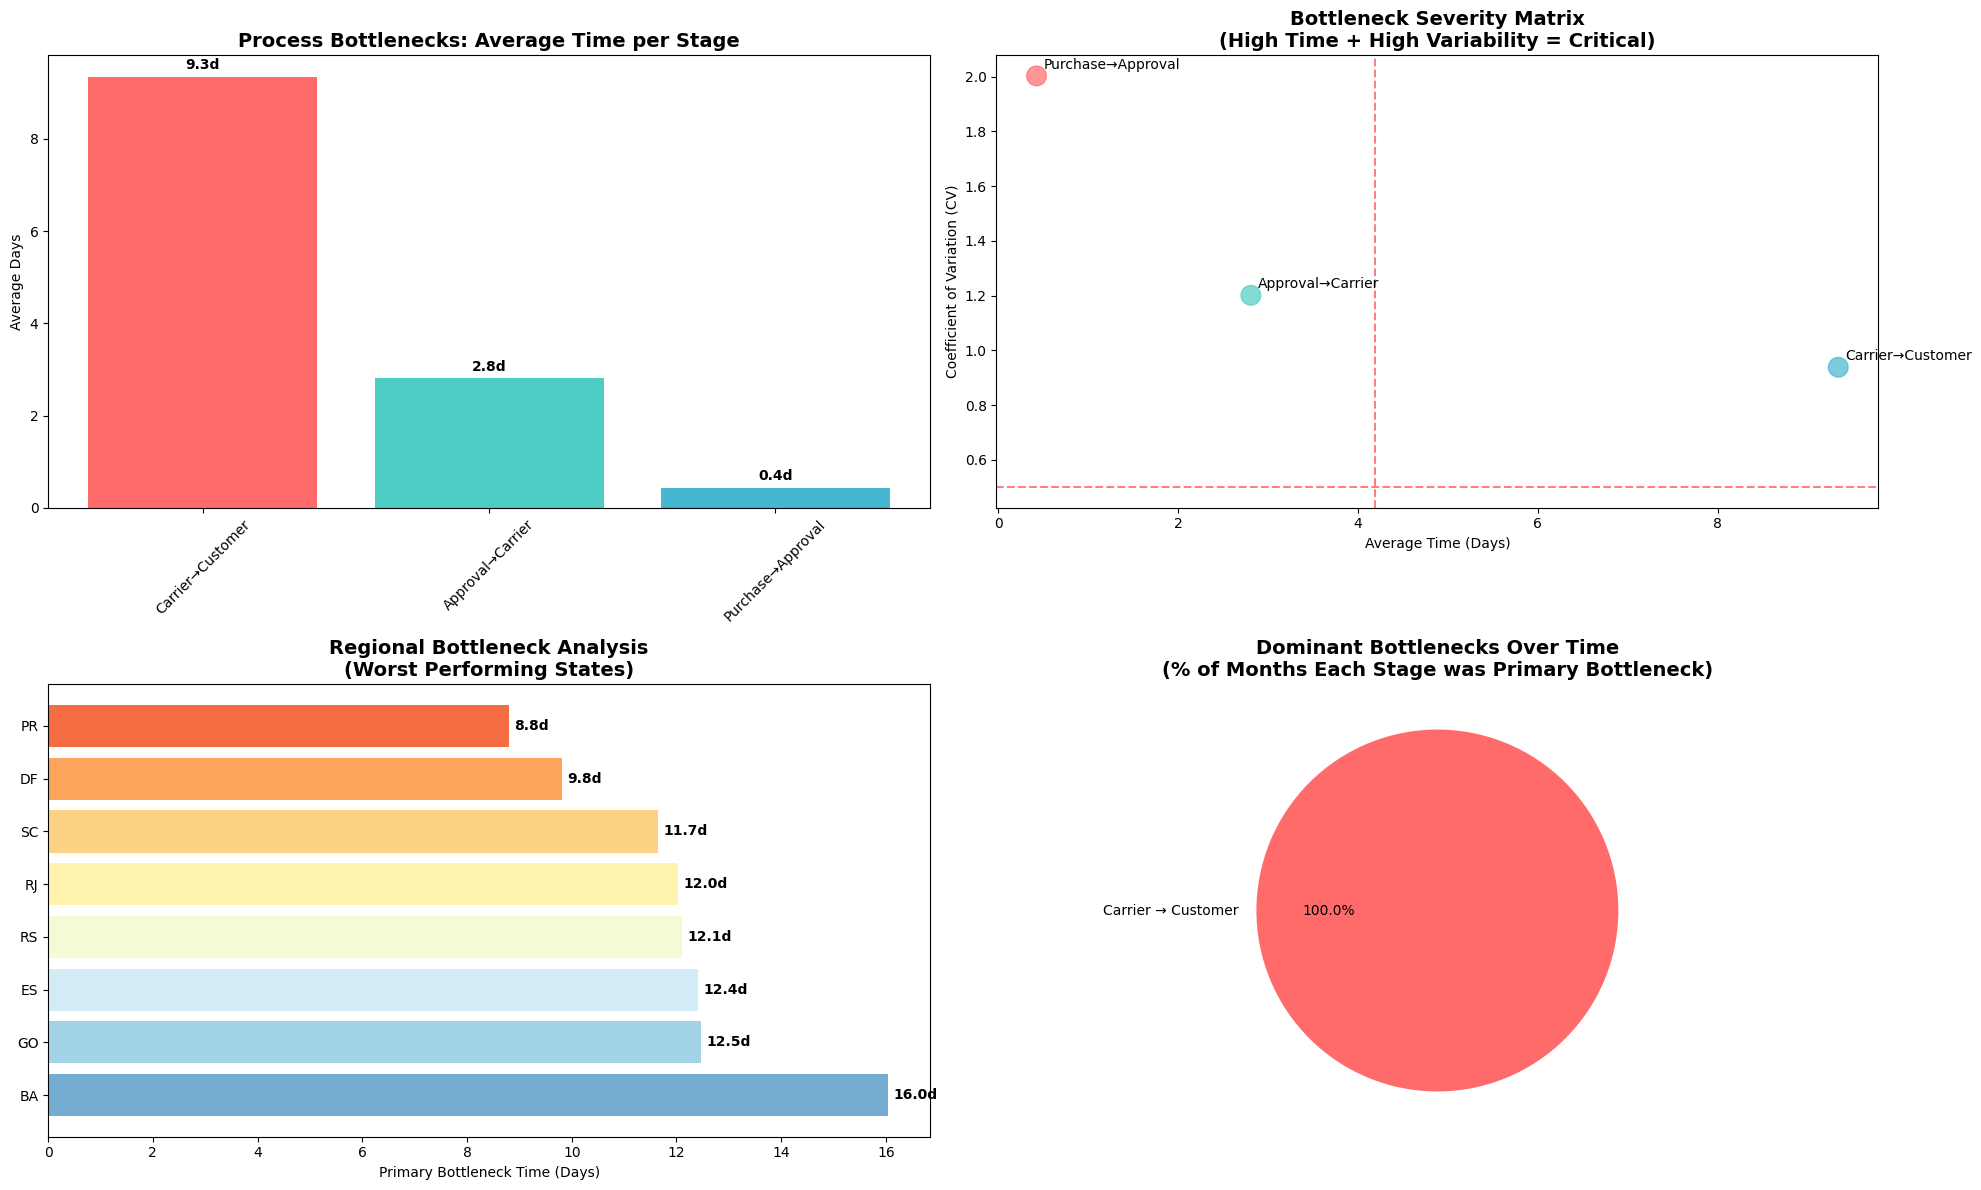

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Stage Time Contribution (Waterfall-style)
stages_sorted = sorted(stage_stats.items(), key=lambda x: x[1]['mean_hours'], reverse=True)
stage_names_short = [s[0].replace(' → ', '→') for s in stages_sorted]
stage_times_days = [s[1]['mean_hours']/24 for s in stages_sorted]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(stage_names_short, stage_times_days, color=colors[:len(stage_times_days)])
ax1.set_title('Process Bottlenecks: Average Time per Stage', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Days')
ax1.tick_params(axis='x', rotation=45)

for bar, days in zip(bars, stage_times_days):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{days:.1f}d', ha='center', va='bottom', fontweight='bold')

# Plot 2: Variability vs Time Matrix
scatter = ax2.scatter([s['mean_hours']/24 for s in stage_stats.values()],
                     [s['cv'] for s in stage_stats.values()],
                     s=200, c=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)

ax2.set_xlabel('Average Time (Days)')
ax2.set_ylabel('Coefficient of Variation (CV)')
ax2.set_title('Bottleneck Severity Matrix\n(High Time + High Variability = Critical)', fontsize=14, fontweight='bold')

for i, (stage, stats) in enumerate(stage_stats.items()):
    ax2.annotate(stage.replace(' → ', '→'), 
                (stats['mean_hours']/24, stats['cv']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# Add quadrant lines
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='High Variability Threshold')
ax2.axvline(x=np.mean([s['mean_hours']/24 for s in stage_stats.values()]), 
           color='red', linestyle='--', alpha=0.5, label='High Time Threshold')

# Plot 3: Regional Bottleneck Heatmap
if len(regional_bottlenecks_df) > 0:
    top_states = regional_bottlenecks_df.head(8)
    y_pos = np.arange(len(top_states))
    
    bars = ax3.barh(y_pos, top_states['bottleneck_time_days'], 
                   color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(top_states))))
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(top_states['state'])
    ax3.set_xlabel('Primary Bottleneck Time (Days)')
    ax3.set_title('Regional Bottleneck Analysis\n(Worst Performing States)', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, (bar, days) in enumerate(zip(bars, top_states['bottleneck_time_days'])):
        width = bar.get_width()
        ax3.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                f'{days:.1f}d', ha='left', va='center', fontweight='bold')

# Plot 4: Temporal Evolution
if len(monthly_df) > 0:
    # Count bottleneck occurrences by stage over time
    bottleneck_counts = monthly_df['dominant_bottleneck'].value_counts()
    
    ax4.pie(bottleneck_counts.values, labels=bottleneck_counts.index, autopct='%1.1f%%',
           colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax4.set_title('Dominant Bottlenecks Over Time\n(% of Months Each Stage was Primary Bottleneck)', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


<h5>This analysis reveals that the delivery stage from the carrier to the customer is the most significant bottleneck, accounting for 9.3 days, or 77% of the total process time. In addition, the approval process shows considerable variability, which increases the likelihood of further delays. At the regional level, performance in the northern and northeastern states is notably weaker, with Bahia (BA) standing out as being, on average, six days slower than most other regions. Finally, the carrier-to-customer delivery stage consistently emerges as the critical bottleneck across all months, representing the single most persistent source of delay in the overall process</h5>

In [42]:
from IPython.display import display, Markdown

report = "## OPERATIONAL EFFICIENCY RECOMMENDATIONS\n\n"

# Identify critical bottlenecks
critical_bottlenecks = []
for stage, stats in stage_stats.items():
    severity_score = (stats['mean_hours']/24) * (1 + stats['cv'])  # Time weighted by variability
    critical_bottlenecks.append({
        'stage': stage,
        'severity_score': severity_score,
        'avg_days': stats['mean_hours']/24,
        'variability': stats['cv']
    })

critical_bottlenecks = sorted(critical_bottlenecks, key=lambda x: x['severity_score'], reverse=True)

# Bottleneck ranking
report += "### Critical Bottleneck Priority Ranking\n"
report += "| Priority | Stage | Severity | Avg Days | Variability |\n"
report += "|----------|-------|----------|----------|-------------|\n"

for i, bottleneck in enumerate(critical_bottlenecks, 1):
    stage = bottleneck['stage']
    severity = bottleneck['severity_score']
    days = bottleneck['avg_days'] 
    variability = "High" if bottleneck['variability'] > 1.0 else "Medium" if bottleneck['variability'] > 0.5 else "Low"
    
    report += f"| {i} | {stage} | {severity:.1f} | {days:.1f} | {variability} |\n"

# Recommendations
report += "\n### Recommended Immediate Actions\n"
top_bottleneck = critical_bottlenecks[0]
report += f"- **Priority 1:** Focus on **{top_bottleneck['stage']}** stage  \n"
report += f"  • Average time: {top_bottleneck['avg_days']:.1f} days  \n"
report += "  • This stage accounts for the highest severity score  \n"
report += "  • Recommended: Process analysis and capacity optimization  \n"

if len(regional_bottlenecks_df) > 0:
    worst_region = regional_bottlenecks_df.iloc[0]
    report += f"\n- **Priority 2:** Address regional disparities  \n"
    report += f"  • Worst performing region: {worst_region['state']}  \n"
    report += f"  • Primary bottleneck: {worst_region['primary_bottleneck']}  \n"
    report += "  • Recommended: Regional logistics review  \n"

high_variability_stages = [s for s in critical_bottlenecks if s['variability'] > 0.5]
if high_variability_stages:
    report += f"\n- **Priority 3:** Reduce process variability  \n"
    report += f"  • Stages with high variability: {len(high_variability_stages)}  \n"
    report += "  • Focus on standardization and process control  \n"

# Business impact
total_improvement_potential = sum([b['avg_days'] for b in critical_bottlenecks]) * 0.2
report += "\n### Estimated Business Impact\n"
report += f"- Potential delivery time reduction: **{total_improvement_potential:.1f} days**  \n"
report += f"- Focus areas cover **{len(critical_bottlenecks)} operational stages**  \n"
report += f"- Regional optimization could impact **{len(regional_bottlenecks_df) if len(regional_bottlenecks_df) > 0 else 0} major markets**  \n"

# Next steps
report += "\n### Next Steps for Implementation\n"
report += "1. Deep-dive analysis on the top bottleneck stage  \n"
report += "2. Benchmark best-performing regions for process insights  \n"
report += "3. Implement monitoring dashboards for real-time bottleneck tracking  \n"
report += "4. Establish KPIs for each stage with improvement targets  \n"
report += "5. Regular review cycles to track bottleneck evolution  \n"

# Display nicely
display(Markdown(report))


## OPERATIONAL EFFICIENCY RECOMMENDATIONS

### Critical Bottleneck Priority Ranking
| Priority | Stage | Severity | Avg Days | Variability |
|----------|-------|----------|----------|-------------|
| 1 | Carrier → Customer | 18.1 | 9.3 | Medium |
| 2 | Approval → Carrier | 6.2 | 2.8 | High |
| 3 | Purchase → Approval | 1.3 | 0.4 | High |

### Recommended Immediate Actions
- **Priority 1:** Focus on **Carrier → Customer** stage  
  • Average time: 9.3 days  
  • This stage accounts for the highest severity score  
  • Recommended: Process analysis and capacity optimization  

- **Priority 2:** Address regional disparities  
  • Worst performing region: BA  
  • Primary bottleneck: Carrier → Customer  
  • Recommended: Regional logistics review  

- **Priority 3:** Reduce process variability  
  • Stages with high variability: 3  
  • Focus on standardization and process control  

### Estimated Business Impact
- Potential delivery time reduction: **2.5 days**  
- Focus areas cover **3 operational stages**  
- Regional optimization could impact **10 major markets**  

### Next Steps for Implementation
1. Deep-dive analysis on the top bottleneck stage  
2. Benchmark best-performing regions for process insights  
3. Implement monitoring dashboards for real-time bottleneck tracking  
4. Establish KPIs for each stage with improvement targets  
5. Regular review cycles to track bottleneck evolution  
